
**Comentario del Revisor**

Hola!

Soy Juan Manuel Romero, pero siéntete libre de llamarme Juanma. Soy code reviewer en Tripleten y hoy estaré revisando tu entrega.

Para simular la dinámica de un ambiente de trabajo, si veo algún error, en primer instancia solo los señalaré, dándote la oportunidad de encontrarlos y corregirlos por tu cuenta. En un trabajo real, el líder de tu equipo hará una dinámica similar. En caso de que no puedas resolver la tarea, te daré una información más precisa en la próxima revisión. 

Solo un aviso rápido: cuando estés revisando el proyecto, por favor deja mis comentarios originales tal como están. De esta manera, podemos seguir fácilmente el progreso y asegurarnos de que no se nos pase nada por alto. Y, si realizas algún cambio basado en mis comentarios, sería genial si pudieras resaltar esas actualizaciones para que se destaquen.

Puedes encontrar mis comentarios en cajas verdes, amarillas o rojas como estas:

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor</b> <a class="tocSkip"></a>

Éxito. Todo se ha hecho correctamente.

</div>


<div class="alert alert-block alert-warning"> 
<b>Comentario del Revisor</b> <a class="tocSkip"></a>

Observaciones. Algunas recomendaciones.

</div> 


<div class="alert alert-block alert-danger">
<b>Comentario del Revisor</b> <a class="tocSkip"></a>

Requiere corrección. El bloque requiere algunas correcciones. El trabajo no puede ser aceptado con los comentarios en rojo.

</div>

Puedes responderme usando esto:

<div class="alert alert-block alert-info"> <b>Respuesta del estudiante.</b> <a class="tocSkip"></a> </div>

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("C:\\Users\\aylin\\Downloads\\taxi.csv")

In [3]:
data.info()
display(data.describe())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Verificación de datos nulos o duplicados

In [4]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


<span style='color:green'> Podemos observar que no había filas duplicadas y que la columna 'datetime' necesita una conversión así como volverla la columna índice </span>

### Modificación de la columna 'datetime'

In [5]:
data['datetime'] = data['datetime'].astype('datetime64[ns]')

In [6]:
data.set_index('datetime', inplace = True)
data.sort_index(inplace = True)



In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Remuestreo

<span style='color:green'> Como el periodo de tiempo es extenso y se requiere hacer el remuestreo, entonces se tomar un día aleatoriamente. En este caso el último para realizar la prueba </span>

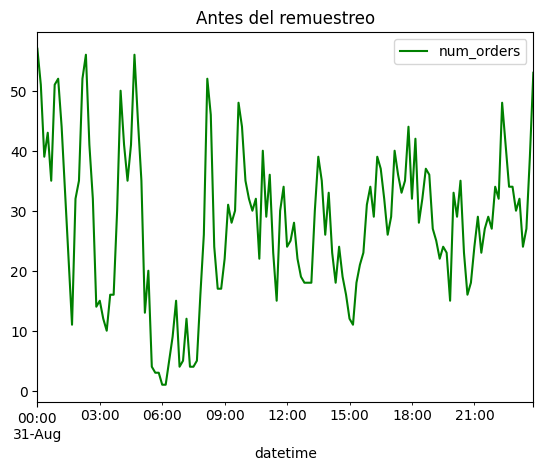

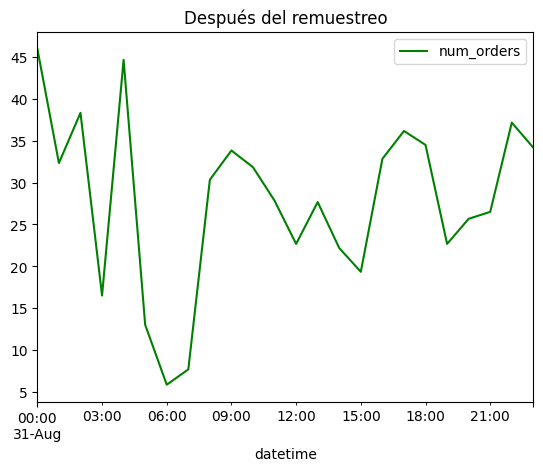

In [8]:
data['2018-08-31':'2018-08-31'].plot(title = 'Antes del remuestreo', c='green')
data = data.resample('1h').mean()
data['2018-08-31':'2018-08-31'].plot(title = 'Después del remuestreo', c='green')
plt.show()

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Buen trabajo! Los datos han sido remuestreados correctamente. Esto permitirá un análisis más claro de los patrones por hora.
    
<div class="alert alert-block alert-warning"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

También podrías haber utilizado `df.resample('1H').sum()`, que agrupa los datos del DataFrame `df` en intervalos de 1 hora y luego suma los valores de cada columna numérica dentro de cada intervalo de hora.

</div>

</div>

## Análisis

<span style='color:green'> Tomamos un valor de la ventana 3 que no es tan alto para poder ver los cambios en un periodo de una semana y continuar ocn el entrenamiento de los modelos. </span>

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

La descomposición de la serie te ha permitido identificar las tendencias y estacionalidades. Esto añade un nivel de análisis profundo a tu trabajo.

</div>

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667
...,...
2018-08-31 19:00:00,22.666667
2018-08-31 20:00:00,25.666667
2018-08-31 21:00:00,26.500000


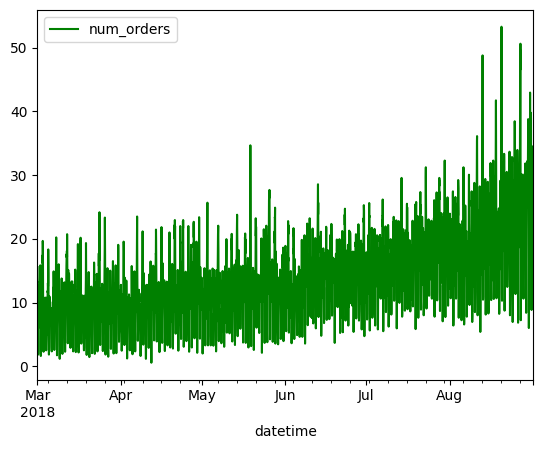

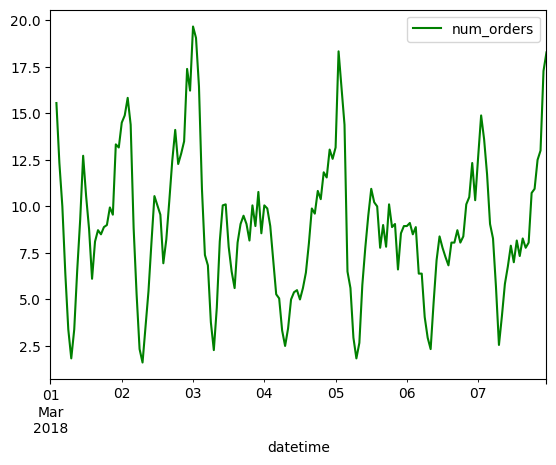

In [9]:
data.rolling(3).mean().plot(c ='green')
data.rolling(3).mean()["2018-03-01":"2018-03-07"].plot(c ='green')
data

<span style='color:green'> En ambos casos se suavizaron los datos, con la serie completa podemos observar momentos de alta y baja demanda, la estacionalidad podría estar relacionada a las horas en las que hay más gente recurriendo al servicio. Con la serie temporal podemos apreciar que existe demanda de acuerdo a las horas del transcurso del día (sobretodo al amanecer que es cuando está el pico más bajo) </span>

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Excelente trabajo Aylin!

</div>

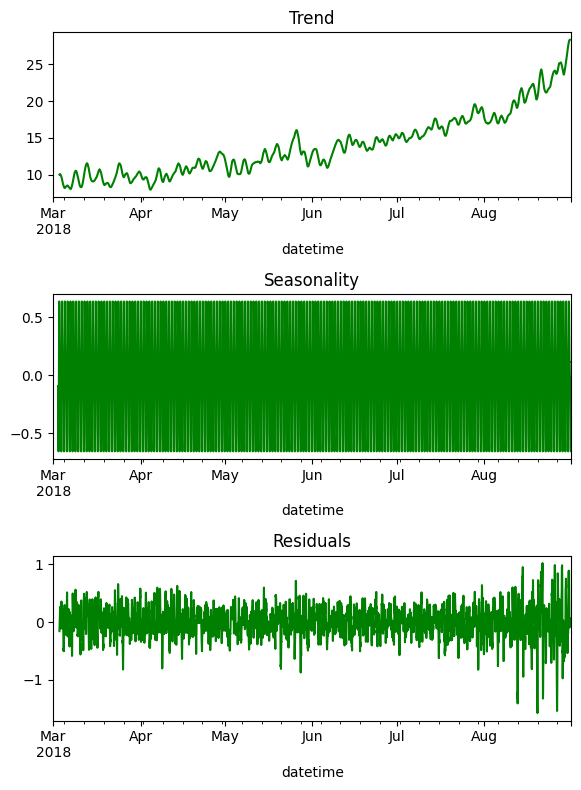

In [10]:
decomposed = seasonal_decompose(data)


H_per_week=int((24*7)/4)
plt.figure(figsize=(6, 8))


plt.subplot(311)
decomposed.trend.rolling(H_per_week).mean().plot(ax=plt.gca(), c ='green')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.rolling(H_per_week).mean().plot(ax=plt.gca(), c ='green')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.rolling(H_per_week).mean().plot(ax=plt.gca(), c ='green')
plt.title('Residuals')
plt.tight_layout()

<span style='color:green'> Lo que estamso visualizando en cuando a la Tendencia es que de acuerdo al paso del tiempo está aumentando y es un punto positivo para la empresa por lo que tiene una ventana de oportunidad para mejorar y optimizar los recursos para que la demanda no sobrepase los límites sanos de lo que puede se puede ofrecer. Y la estacionalidad debido a que la dividimos de acuerdo a las horas es bastante constante y seguro que hay algún patrón de horas pico o alta demanda </span>

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Fantástico! Has identificado tanto la tendencia de aumento de pedidos como la estacionalidad diaria. Esto demuestra una comprensión clara de los patrones subyacentes.

</div>

<Axes: xlabel='datetime'>

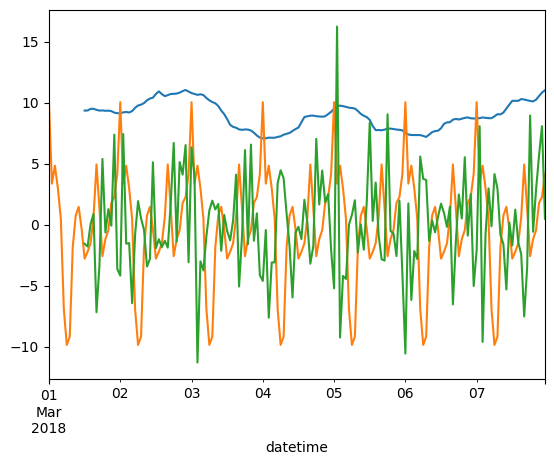

In [11]:
decomposed.trend["2018-03-01":"2018-03-07"].plot()
decomposed.seasonal["2018-03-01":"2018-03-07"].plot()
decomposed.resid["2018-03-01":"2018-03-07"].plot()

### Diferencia de serie temporal

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,20.666667
2018-03-01 02:00:00,14.166667
2018-03-01 03:00:00,11.833333
2018-03-01 04:00:00,11.000000
...,...
2018-08-31 19:00:00,34.500000
2018-08-31 20:00:00,22.666667
2018-08-31 21:00:00,25.666667


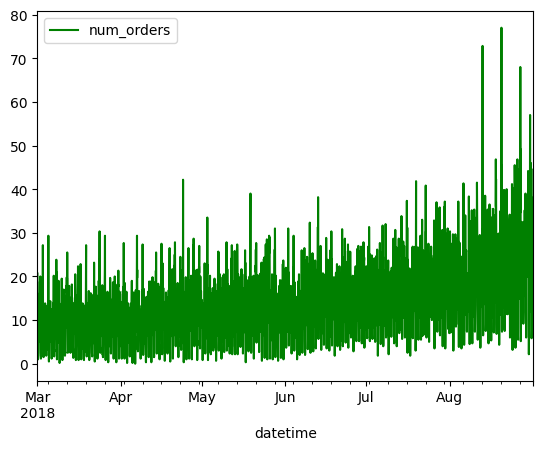

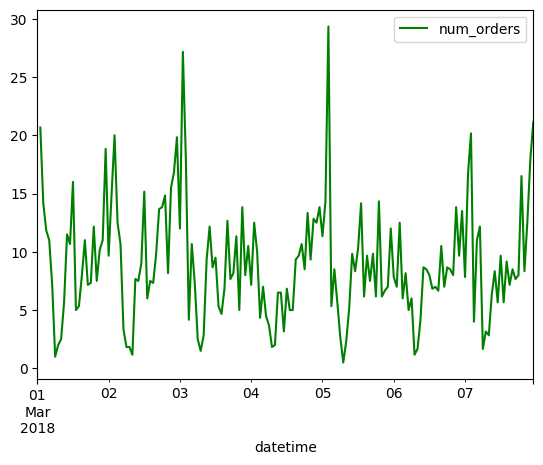

In [12]:
data.shift().plot(c = 'green')
data["2018-03-01":"2018-03-07"].shift().plot(c = 'green')
data.shift()

### Formación

<span style='color:green'> Vamos a generar las características que servirán para nuestro objetivo 'num_orders' </span>

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data.dropna(inplace=True)
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)
    
    data["rolling_mean"]=data.iloc[:,0].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

    decomposed = seasonal_decompose(data.iloc[:, 0], model='additive', period=rolling_mean_size)
    
    data['trend'] = decomposed.trend
    data['seasonal'] = decomposed.seasonal
    data.dropna(inplace=True)

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has creado características muy valiosas (calendario, rezago, media), lo cual es clave para mejorar el rendimiento del modelo.

</div>

<span style='color:green'> Se aplicará antes de hacer la división de datos y que estos estén completos. Se busca la correlación entre nuestras variables. </span>

In [14]:
#Se toman como parámetros de entrada la info de las ultimas horas que estpa diponible
make_features(data,5,5)
data.corr()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,trend,seasonal
num_orders,1.000000,NaN,0.509359,0.162444,-0.020339,0.622860,0.464459,0.320267,0.247188,0.228140,0.493961,0.832274,0.009945
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.509359,NaN,1.000000,0.000418,-0.012325,0.509668,0.509794,0.509914,0.509423,0.508969,0.668245,0.667727,0.000196
day,0.162444,NaN,0.000418,1.000000,-0.014263,0.163160,0.164040,0.164066,0.163859,0.162678,0.214499,0.211218,0.001204
dayofweek,-0.020339,NaN,-0.012325,-0.014263,1.000000,-0.027925,-0.029956,-0.029379,-0.029168,-0.029454,-0.038263,-0.021368,0.000150
lag_1,0.622860,NaN,0.509668,0.163160,-0.027925,1.000000,0.622879,0.464395,0.319658,0.246428,0.696120,0.794448,-0.006099
lag_2,0.464459,NaN,0.509794,0.164040,-0.029956,0.622879,1.000000,0.622827,0.463946,0.319025,0.794553,0.696279,0.001995
lag_3,0.320267,NaN,0.509914,0.164066,-0.029379,0.464395,0.622827,1.000000,0.622749,0.463717,0.832499,0.494573,0.001824
lag_4,0.247188,NaN,0.509423,0.163859,-0.029168,0.319658,0.463946,0.622749,1.000000,0.622070,0.794220,0.393019,-0.005619
lag_5,0.228140,NaN,0.508969,0.162678,-0.029454,0.246428,0.319025,0.463717,0.622070,1.000000,0.695139,0.346917,0.009810


<span style='color:green'> Observamos la alta correlación entre num_orders y lag_1 </span>

## Procesamiento de datos

### División de datos

Set de test: 10%

Set de validación: 20%

Set de training: 70%

In [15]:
train, test = train_test_split(data, shuffle= False, test_size= 0.1)
train, valid = train_test_split(train, shuffle= False, test_size= 0.2)


In [16]:
train_target= train.iloc[:,0]
train_features=train.drop('num_orders',axis=1)
valid_target= test.iloc[:,0]
valid_features=test.drop('num_orders',axis=1)
test_target= test.iloc[:,0]
test_features=test.drop('num_orders',axis=1)

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has realizado correctamente la división de entrenamiento y prueba de forma secuencial, lo que es esencial para respetar la naturaleza temporal de los datos.

</div>

### Escalado de características

<span style='color:green'> Escalaremos las características ya que para algunos modelos es necesario este paso para que pueda funcionar correctamente </span>

In [17]:
Numeric = list(range(len(train_features.columns)))
Numeric = [x for x in Numeric if x not in [1, 2, 3]]
scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled=scaler.transform(train_features)
valid_features_scaled=scaler.transform(valid_features)
test_features_scaled=scaler.transform(test_features)

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Correcto, buen trabajo

</div>

## Modelos 

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Excelente trabajo! Has considerado varios modelos diferentes, lo que te permite comparar enfoques y elegir el mejor.

</div>

### Regresión Lineal

In [18]:
%%time
model=LinearRegression()
model.fit(train_features_scaled,train_target)
train_predictions=model.predict(train_features_scaled)
valid_predictions=model.predict(valid_features_scaled)

train_error_lineal=root_mean_squared_error(train_predictions,train_target)
valid_error_lineal=root_mean_squared_error(valid_predictions,valid_target)
test_error_lineal = root_mean_squared_error( model.predict(test_features_scaled),test_target)

print("RECM para el conjunto de entrenamiento:",root_mean_squared_error(train_predictions,train_target)) 
print("RECM para el conjunto de prueba:",valid_error_lineal) 

RECM para el conjunto de entrenamiento: 3.36549206983759
RECM para el conjunto de prueba: 5.952054007527279
CPU times: total: 0 ns
Wall time: 9.97 ms


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Excelente trabajo entrenando y validando los modelos.
    
<div class="alert alert-block alert-warning"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Solo recuerda utilizar el conjunto de test al final, con el modelo elegido. Utilizarlo para comparar modelos crea un sesgo que queremos evitar.

</div>

</div>

### Árbol aleatorio de regresión

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Has seleccionado los hiperparámetros correctamente, utilizando la muestra adecuada, lo que optimizará el rendimiento del modelo.

</div>

In [19]:
%%time
model = DecisionTreeRegressor(random_state=54321)
param_grid = {
    'max_depth': [1, 3, 5, 10, None],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_features, train_target)
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(train_features)
valid_predictions = best_model.predict(valid_features)

train_error_tree=root_mean_squared_error(train_predictions,train_target)
valid_error_tree=root_mean_squared_error(valid_predictions, valid_target)
test_error_tree = root_mean_squared_error( best_model.predict(test_features),test_target)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("RECM para el conjunto de entrenamiento:", root_mean_squared_error(train_predictions, train_target)) 
print("RECM para el conjunto de prueba:", valid_error_tree)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 8}
RECM para el conjunto de entrenamiento: 3.2602879029700964
RECM para el conjunto de prueba: 8.273418620649318
CPU times: total: 359 ms
Wall time: 4.73 s


### Bosque de regresión 

In [20]:
%%time
model = RandomForestRegressor(random_state=54321)

param_grid = {
    'n_estimators': [100, 200, 300, 400],  
    'max_depth': [5, 10, 20, 30, None],  
    'min_samples_leaf': [1, 4, 8],  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_features, train_target)

best_model = grid_search.best_estimator_

train_predictions = best_model.predict(train_features)
valid_predictions = best_model.predict(valid_features)

train_error_forest=root_mean_squared_error(train_predictions,train_target)
valid_error_forest=root_mean_squared_error(valid_predictions, valid_target)
test_error_forest = root_mean_squared_error( best_model.predict(test_features),test_target)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("RECM para el conjunto de entrenamiento:", root_mean_squared_error(train_predictions, train_target)) 
print("RECM para el conjunto de prueba:", valid_error_forest)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}
RECM para el conjunto de entrenamiento: 2.2374123340336785
RECM para el conjunto de prueba: 8.051444355495024
CPU times: total: 4.27 s
Wall time: 3min 45s


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Gran trabajo!

</div>

### CatBoost con Potenciación de Gradiente

<span style='color:green'> Para este modelo es necesario indicarle cuales son las columnas que son categóricas </span>

In [21]:
indice_cat = [1,2,3]

In [22]:
%%time
best_error = 10000
best_est = 0
best_depth = 0

for est in tqdm(range(10, 101, 10)):
    for depth in range(1, 12, 2):
        model = CatBoostRegressor(iterations=est, depth=depth, random_seed=54321, learning_rate=0.1,loss_function='RMSE',task_type="GPU", verbose=0)

        model.fit(train_features, train_target, cat_features=indice_cat)
        valid_predictions = model.predict(valid_features)
        error = root_mean_squared_error(valid_target, valid_predictions)
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth


train_error_GB = root_mean_squared_error( model.predict(train_features),train_target)
valid_error_GB= best_error
test_error_GB = root_mean_squared_error( model.predict(test_features),test_target)

print(f"Mejores hiperparámetros: n_estimators: {best_est}, best_depth: {best_depth}")
print("RECM del mejor modelo en el conjunto de entrenamiento:", train_error_GB)
print(f"RECM del mejor modelo en el conjunto de validación: {valid_error_GB}")

100%|██████████| 10/10 [00:50<00:00,  5.07s/it]

Mejores hiperparámetros: n_estimators: 70, best_depth: 3
RECM del mejor modelo en el conjunto de entrenamiento: 2.1956904225881146
RECM del mejor modelo en el conjunto de validación: 7.999448188572034
CPU times: total: 38.5 s
Wall time: 50.8 s


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Todos los rsultados se presentan de forma clara. 
</div>

### Tabla con info de todos los modelos

In [23]:
modelos = ['Regresión_lineal', 'Árbol_de_regresión', 'Bosque_de_regresión', 'CatBoost_con_PG']
train_errors = [train_error_lineal, train_error_tree, train_error_forest, train_error_GB]
valid_errors = [valid_error_lineal, valid_error_tree, valid_error_forest, valid_error_GB]
test_errors = [test_error_lineal, test_error_tree, test_error_forest, test_error_GB]

df = pd.DataFrame({
    "Error de Entrenamiento": train_errors,
    'Error de Validación': valid_errors,
    'Error de Test': test_errors
}, index=modelos)

display(df)

,Error de Entrenamiento,Error de Validación,Error de Test
Regresión_lineal,3.365492,5.952054,5.952054
Árbol_de_regresión,3.260288,8.273419,8.273419
Bosque_de_regresión,2.237412,8.051444,8.051444
CatBoost_con_PG,2.195690,7.999448,9.120830


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Fantástico! Has logrado un RMSE menor a 48, lo que indica un buen rendimiento del modelo.

</div>

## Conclusiones

El modelo de regresión lineal sería el mejor modelo a escoger de acuerdo a sus resultados ya que no tiene sobreajuste y sus errores en los sets de validacion y en test son los más bajos. También considerando que es un modelo rapido es también fácil de entrenar. Ahora bien, el modelo CatBoost también por su manejo de los datos podría ser utilizado para capturar relaciones más complejas si la empresa por ejemplo quisiera ver más alla de los datos que nos proporcionan ya que es capaz de tener en cuenta información que la Regresión lineal por su naturaleza no es posible. 

<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Genial! Has presentado claramente los hallazgos y elegido el mejor modelo. Esto es fundamental para una interpretación precisa de los resultados. Además, tomaste en cuenta no solo los resultados, si no también el tiempo y uso computacional de los mismos, lo que en muchos casos es fundamental.

</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el mo]delo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48


<div class="alert alert-block alert-success"> 
<b>Comentario del Revisor #1</b> <a class="tocSkip"></a>

Felicidades Aylin! Tu trabajo es excelente.

Has completado todos los items necesarios para aprobar la entrega.

Sigue así!

</div>